In [13]:
import pandas as pd
import numpy as np
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('../train/train.csv')

In [14]:
from sklearn.model_selection import train_test_split

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(train.iloc[:, :-1], train.iloc[:, -1], test_size=0.3, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(train.iloc[:, :-1], train.iloc[:, -1], test_size=0.3, random_state=0)

In [15]:
# Loss Function Customizing
def xgb_quantile_eval(quantile):
    def loss(preds, dmatrix):
        labels = dmatrix.get_label()
        return ('q{}_loss'.format(quantile),
                np.nanmean((preds >= labels) * (1 - quantile) * (preds - labels) +
                           (preds < labels) * quantile * (labels - preds)))
    return loss

# Loss Function Customizing
def xgb_quantile_obj(quantile):
    def loss(labels, preds):
        try:
            assert 0 <= quantile <= 1
        except AssertionError:
            raise ValueError("Quantile value must be float between 0 and 1.")

        errors = preds - labels

        left_mask = errors < 0
        right_mask = errors > 0

        grad = -quantile * left_mask + (1 - quantile) * right_mask
        hess = np.ones_like(preds)

        return grad, hess
    return loss

In [16]:
from xgboost import XGBRegressor
import xgboost as xgb

def XGB(q, X_train, Y_train, X_valid, Y_valid):    
    model = XGBRegressor(objective=xgb_quantile_obj(quantile=q), seed=2021,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.1, subsample=0.7)                 
                         
    model.fit(X_train, Y_train, eval_metric=xgb_quantile_eval(quantile=q), 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    return model

In [17]:
# Target 예측

def train_data_XGB(X_train, Y_train, X_valid, Y_valid):

    XGB_models=[]
    XGB_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        model = XGB(q, X_train, Y_train, X_valid, Y_valid)
        XGB_models.append(model)
        
    return XGB_models

In [18]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [19]:
# Target1
XGB_1 = train_data_XGB(X_train_1, Y_train_1, X_valid_1, Y_valid_1)
XGB_2 = train_data_XGB(X_train_2, Y_train_2, X_valid_2, Y_valid_2)

0.1
[14:45:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_fraction } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:31.09837	validation_0-q0.1_loss:1.94389
[500]	validation_0-rmse:28.34068	validation_0-q0.1_loss:1.53496
[1000]	validation_0-rmse:25.70865	validation_0-q0.1_loss:1.33858
[1500]	validation_0-rmse:23.19007	validation_0-q0.1_loss:1.16239
[2000]	validation_0-rmse:20.78678	validation_0-q0.1_loss:1.00350
[2500]	validation_0-rmse:18.50155	validation_0-q0.1_loss:0.85995
[3000]	validation_0-rmse:16.34039	validation_0-q0.1_loss:0.73175
[3500]	validation_0-rmse:14.30899	validation_0-q0.1_loss:0.61794
[4000]	validation_0-rmse:12.40965	validation_0-q0.1_loss:0.51964
[4500]	validation_0-r

In [45]:
# Target 예측

def predict_data(model, X_test):
    XGB_actual_pred = pd.DataFrame()

    for i in range(9):
        pred = pd.Series(model[i].predict(X_test).round(2))
        
        XGB_actual_pred = pd.concat([XGB_actual_pred,pred],axis=1)

    XGB_actual_pred.columns=quantiles
    
    return XGB_actual_pred

def create_lag_feats(data, lags, cols):
    
    lag_cols = []
    temp = data.copy()
    for col in cols:
        for lag in lags:
            # 48칸 이동
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            # Target1 = 원래 TARGET값
            # Target2 = 1일 앞으로 댕겼음
            temp['Target1'] = temp['TARGET']
            temp['Target2'] = temp['TARGET'].shift(-48).fillna(method='ffill')
            # lag_cols = 1일 뒤로 밀었음
            lag_cols.append(col + '_lag_%s'%lag)

    return temp, lag_cols   

def preprocess_data(data, target_lags=[48], weather_lags=[48], is_train=True):
    
    temp = data.copy()

    if is_train==True:          
    
        temp, temp_lag_cols1 = create_lag_feats(temp, target_lags, ['TARGET'])
        temp, temp_lag_cols2 = create_lag_feats(temp, weather_lags, ['DHI', 'DNI', 'WS', 'RH', 'T'])
     
        return temp[['Hour'] + temp_lag_cols1 + temp_lag_cols2 + ['Target1', 'Target2']].dropna()

    # Target1, Target2 제거
    elif is_train==False:    
        
        temp, temp_lag_cols1 = create_lag_feats(temp, target_lags, ['TARGET'])
        temp, temp_lag_cols2 = create_lag_feats(temp, weather_lags, ['DHI', 'DNI', 'WS', 'RH', 'T'])
                              
        return temp[['Hour'] + temp_lag_cols1 + temp_lag_cols2].dropna()

In [82]:
df_test = []

for i in range(81):
    file_path = '../test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = temp[288:]
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 9)

In [84]:
result1 =predict_data(XGB_1, X_test.drop(['TARGET'], axis=1))
result2 =predict_data(XGB_2, X_test.drop(['TARGET'], axis=1))

In [132]:
submission = pd.read_csv('../sample_submission.csv')
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = result1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = result2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,-0.68,-1.12,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.01
1,0.csv_Day7_0h30m,-0.63,-1.06,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.01
2,0.csv_Day7_1h00m,-0.32,-0.70,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.01
3,0.csv_Day7_1h30m,-0.77,-0.57,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.01
4,0.csv_Day7_2h00m,-0.17,-0.15,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.01
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,-3.98,-3.15,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.01
7772,80.csv_Day8_22h00m,-3.20,-3.02,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.01
7773,80.csv_Day8_22h30m,-3.85,-3.08,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.01
7774,80.csv_Day8_23h00m,-4.29,-2.87,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.01


In [133]:
for i in range(1, 10):
    submission.iloc[:, i] = submission.iloc[:, i].apply(lambda x : 0 if x<0 else x)

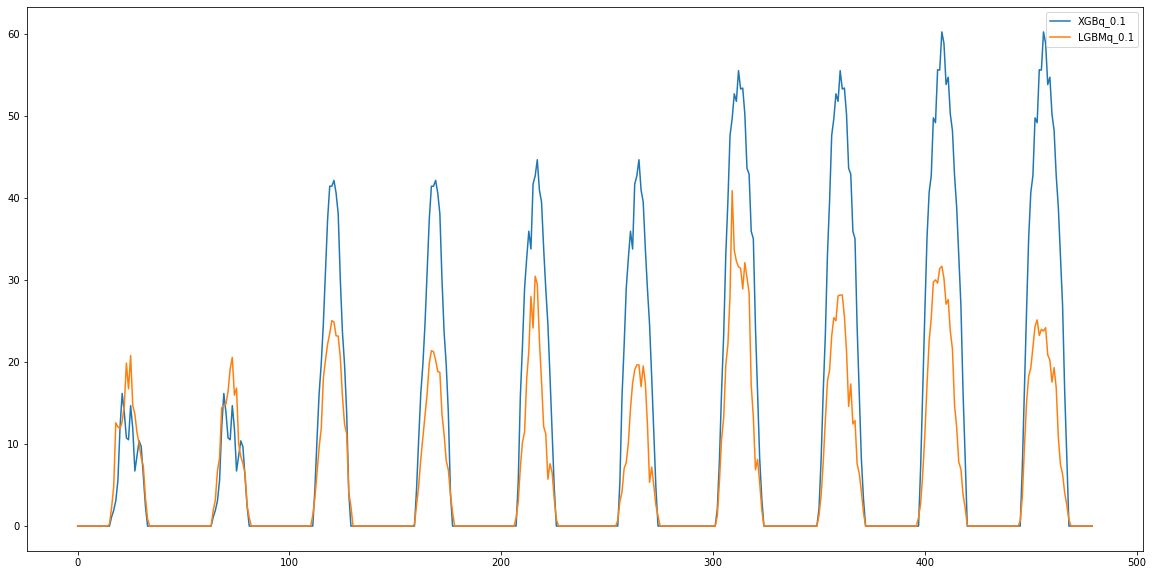

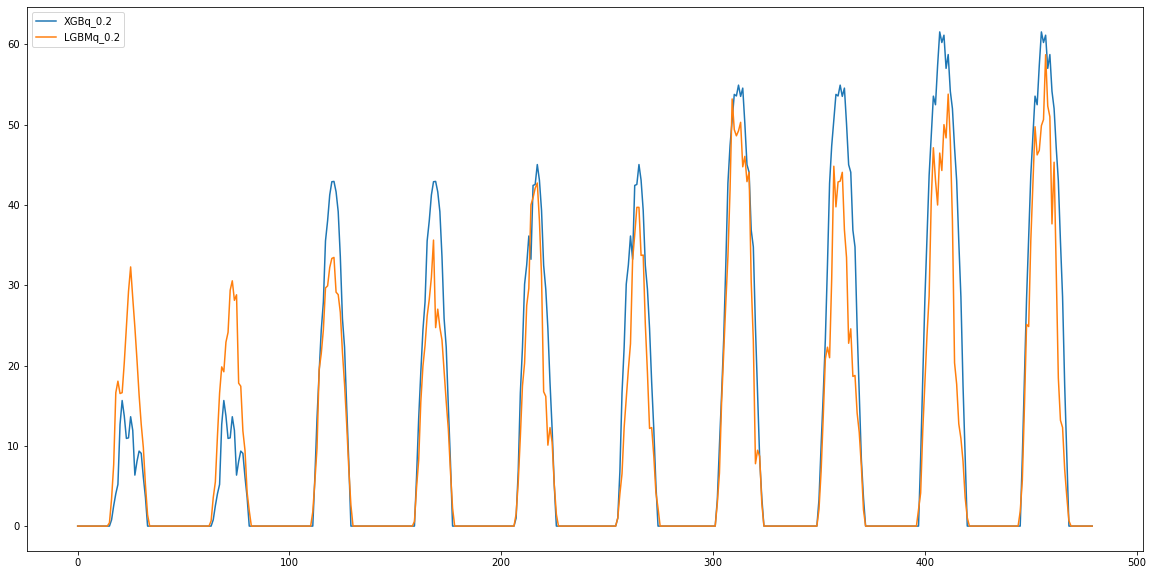

In [137]:
plt.figure(figsize=(20, 10))
plt.plot(submission['q_0.1'][0:480], label='XGBq_0.1')
plt.plot(submission2['q_0.1'][0:480], label='LGBMq_0.1')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(submission['q_0.2'][0:480], label='XGBq_0.2')
plt.plot(submission2['q_0.2'][0:480], label='LGBMq_0.2')
plt.legend()
plt.show()

In [114]:
submission2 = pd.read_csv('../LGBM_EX.csv')

In [134]:
for i in range(len(submission)):
    if 0 in list(submission.loc[i, :]):
        submission.loc[i, 1:] = 0

In [135]:
submission.to_csv('XGB_PREDICT_NO_LAG.csv', index=False)